# peakidentify.py example

This module constains a set of functions designed to attach a label to each fitted peak in an unknown spectra based on fed in known calibration spectra.These functions are primarily accessed in an automated fashion via the peakidentify.py module.

This module contains the following functions:
1. peakidentify.peak_assignment()
2. peakidentify.compare_unknown_to_known()
3. peakidentify.peak_position_comparisons()
4. peakidentify.percentage_of_peaks_found()
5. peakidentify.plotting_peak_assignments()
6. peakidentify.add_label()
7. peakidentify.peak_1d_score()
8. peakidentify.score_max()
9. peakidentify.score_sort()
10. peakidentify.process_score()
11. peakidentify.score_table()

Developed by the Raman-Noodles team (2019 DIRECT Cohort, University of Washington)

### Pre-step (1/3): Import Modules



In [1]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lineid_plot
from ramandecompy import spectrafit
from ramandecompy import peakidentify
from ramandecompy import dataprep
from ramandecompy import datavis


In [2]:
import chempy
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline
sp.__version__, chempy.__version__

('1.3', '0.7.8')

In [3]:
# import classes
from chempy import balance_stoichiometry
from pprint import pprint
from chempy import mass_fractions
# Import packages
from chempy import ReactionSystem 
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

### Pre-step (2/3): Balancing Stoichiometry
Using chemistry, we balance some stoiciometric decomposition equations to inform our decisions of fed-in calibration spectra.
Using `chempy.py`, we can input possible strings for HCOOH formic acid decomposition products. Errors will be thrown if the stoichiometry of the equations is off. Use this as a first test of confidence for your reactions. 



In [4]:
# Reaction System from string 
# The rate constants below are arbitrary
rsys = ReactionSystem.from_string("""
HCOOH -> H2 + CO2; 42
HCOOH -> H2O + CO; 17
""")  # "[H2O]" = 1.0 (actually 55.4 at RT)
reaction, product = balance_stoichiometry({'HCOOH'},{'CO2','H2'})
for fractions in map(mass_fractions, [reaction, product]):
    pprint({k: '{0:.3g} wt%'.format(v*100) for k, v in fractions.items()})
    # .4g is for the number of sig figs 
reaction, product = balance_stoichiometry({'HCOOH'},{'CO','H2O'})
for fractions in map(mass_fractions, [reaction, product]):
    pprint({k: '{0:.3g} wt%'.format(v*100) for k, v in fractions.items()})
    # .4g is for the number of sig figs 
rsys

{'HCOOH': '100 wt%'}
{'CO2': '95.6 wt%', 'H2': '4.38 wt%'}
{'HCOOH': '100 wt%'}
{'CO': '60.9 wt%', 'H2O': '39.1 wt%'}


### Pre-step (3/3):Calibration & Experimental Data Input

Second, we'll generate the dataset that we will use to explore this functionality. This data will be downloaded from the calibration files. In order to generate an "unknown spectrum" that we will be attempting to fit, we download data using `dataprep.add_experiment function`, and feed that in as our unknown dataset. For further explanation of the `dataprep.py` or `spectrafit.py` packages, refer to the Jupyter notebooks which present examples of their usage, also found in this repo.

We will use a list of known spectra from our calibration list and put it in hdf5 format with the `dataprep.py` module. See `dataprep.py` example for more details. The functions `new_hdf5` and `add_calibration` should only be called once or else an File Already exists error will be raised. We use a sapphire data spectra as a calibration compound due to a sapphire ball in the reactor system. Other compounds not within the formic acid reaction are commented out due to the stoichiometry we did above; however, a truly unknown spectra might need several more calibration datasets.

In [5]:
# when you add a new hdf5 file you use this function below
dataprep.new_hdf5('peakidentify_calibration_file')


In [6]:
dataprep.view_hdf5('peakidentify_calibration_file.hdf5') #already have this

**** peakidentify_calibration_file.hdf5 ****


In [7]:
dataprep.add_calibration('peakidentify_calibration_file.hdf5',
                          '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx',
                          label='Hydrogen')
dataprep.add_calibration('peakidentify_calibration_file.hdf5',
                          '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx',
                          label='CarbonMonoxide')
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/CO2_100wt%.csv',label='CO2')
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/water.xlsx',label='H2O')
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/sapphire.xlsx',label='sapphire')
dataprep.add_calibration('peakidentify_calibration_file.hdf5','../ramandecompy/tests/test_files/FormicAcid_3_6percent.xlsx',label='FormicAcid')

Data from ../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.
Data from ../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.
Data from ../ramandecompy/tests/test_files/CO2_100wt%.csv fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.
Data from ../ramandecompy/tests/test_files/water.xlsx fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.
Data from ../ramandecompy/tests/test_files/sapphire.xlsx fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.
Data from ../ramandecompy/tests/test_files/FormicAcid_3_6percent.xlsx fit with compound pseudo-Voigt model.
     Results saved to peakidentify_calibration_file.hdf5.


In [8]:
#checking the components in the file -- these are the pure component spectra only for calibration use
test_example = h5py.File('peakidentify_calibration_file.hdf5', 'r+')
list(test_example.keys())

['CO2', 'CarbonMonoxide', 'FormicAcid', 'H2O', 'Hydrogen', 'sapphire']

In [9]:
#checking the values of the files
list(test_example.values())

[<HDF5 group "/CO2" (5 members)>,
 <HDF5 group "/CarbonMonoxide" (4 members)>,
 <HDF5 group "/FormicAcid" (9 members)>,
 <HDF5 group "/H2O" (5 members)>,
 <HDF5 group "/Hydrogen" (7 members)>,
 <HDF5 group "/sapphire" (7 members)>]

In [10]:
type(test_example) #checking the type of the files

h5py._hl.files.File

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e354add0b8>)

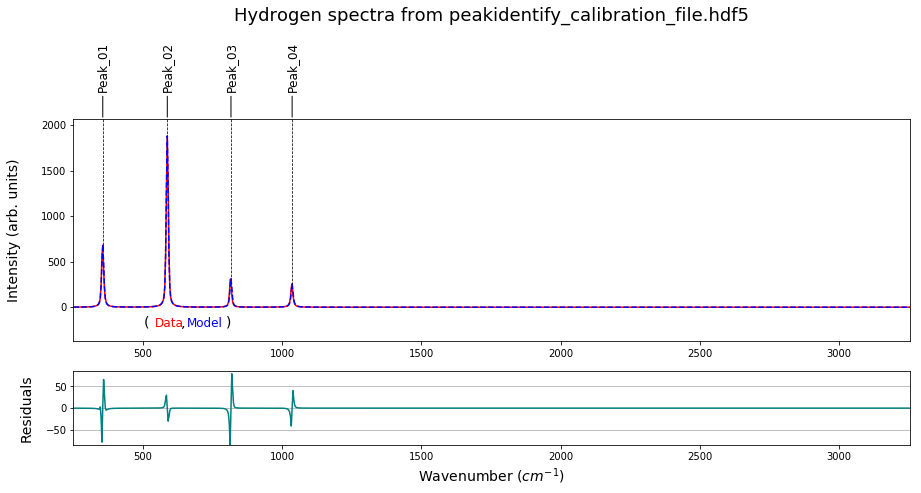

In [11]:
# plotted known spectra with detected peaks
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'Hydrogen') #plotting the hydrogen after going through with dataprep

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e359626d68>)

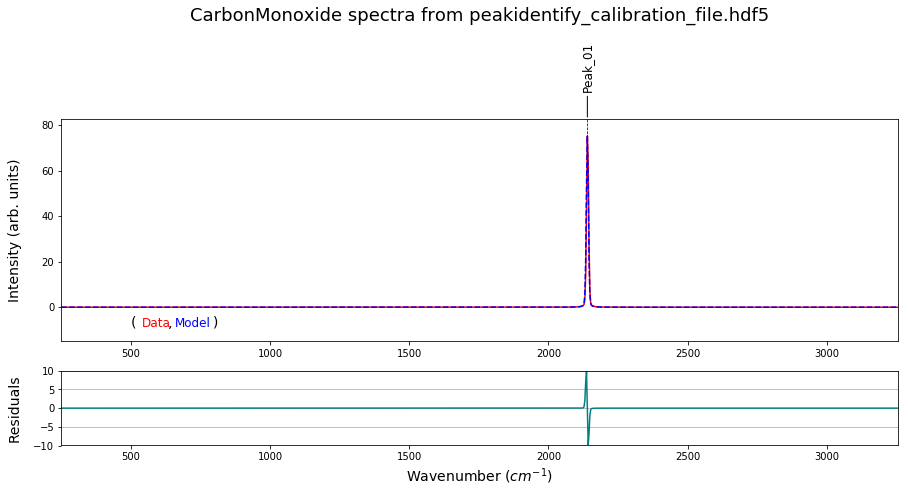

In [12]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'CarbonMonoxide')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e35a8a3a20>)

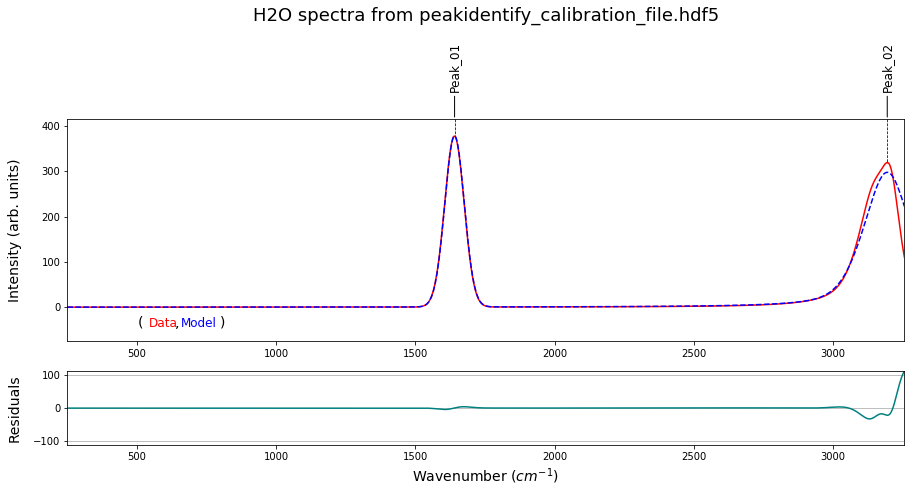

In [13]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'H2O')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e3593fcbe0>)

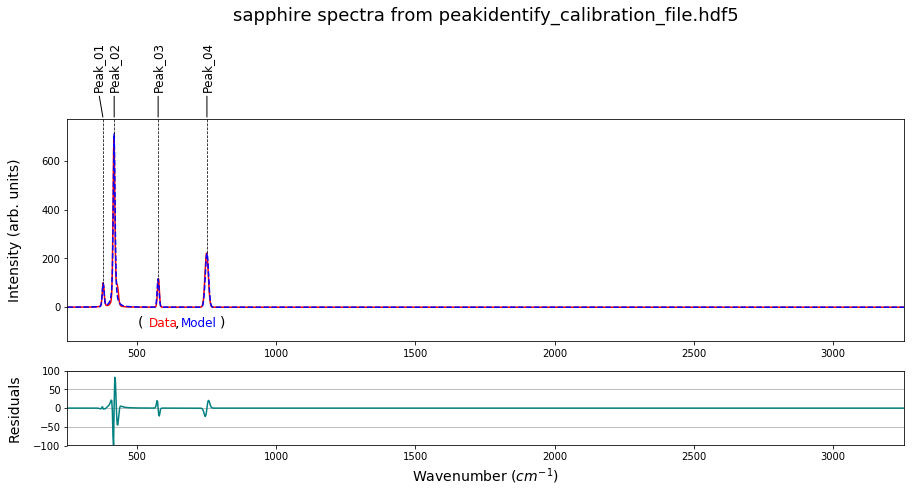

In [14]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'sapphire')

(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e3594fba58>)

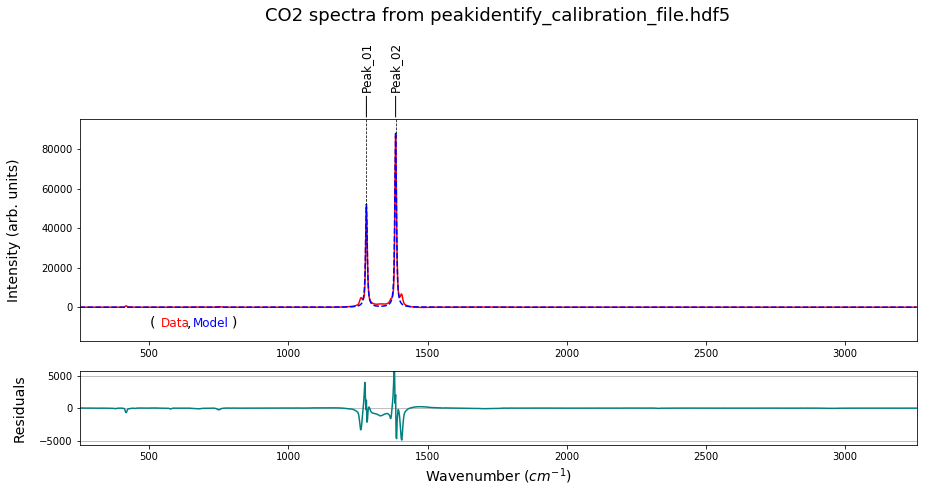

In [15]:
datavis.plot_fit('peakidentify_calibration_file.hdf5', 'CO2')

In [16]:
dataprep.new_hdf5('peakidentify_experiment_file')
dataprep.add_experiment('peakidentify_experiment_file.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv') 

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model.
     Results saved to peakidentify_experiment_file.hdf5.


In [17]:
dataprep.view_hdf5('peakidentify_experiment_file.hdf5')

**** peakidentify_experiment_file.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e3594b89e8>)

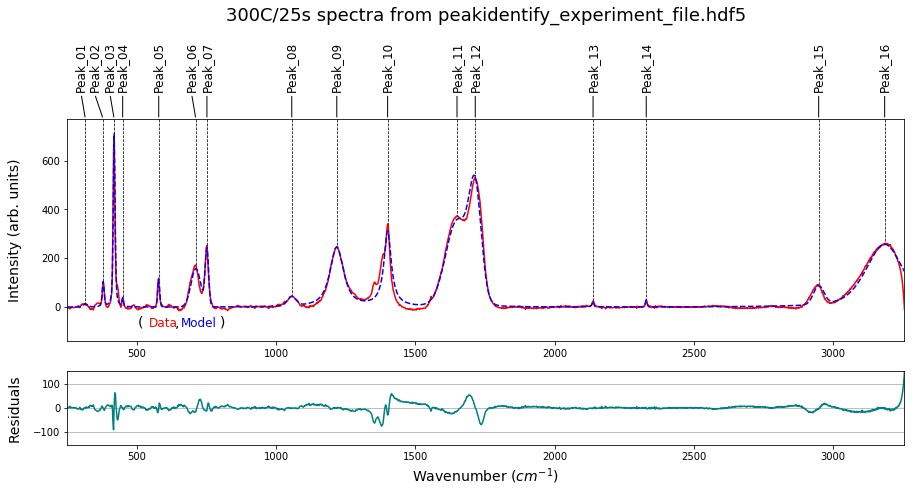

In [18]:
datavis.plot_fit('peakidentify_experiment_file.hdf5', '300C/25s')

In [19]:
dataprep.new_hdf5('peakidentify_label_test')


In [20]:
dataprep.add_experiment('peakidentify_label_test.hdf5', '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model.
     Results saved to peakidentify_label_test.hdf5.


In [21]:
dataprep.view_hdf5('peakidentify_calibration_file.hdf5')

**** peakidentify_calibration_file.hdf5 ****
CO2
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
CarbonMonoxide
|    Peak_01
|    counts
|    residuals
|    wavenumber
FormicAcid
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    Peak_05
|    Peak_06
|    counts
|    residuals
|    wavenumber
H2O
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
Hydrogen
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber
sapphire
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber


In [22]:
dataprep.view_hdf5('peakidentify_label_test.hdf5')

**** peakidentify_label_test.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


(<Figure size 1080x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e354a18b38>)

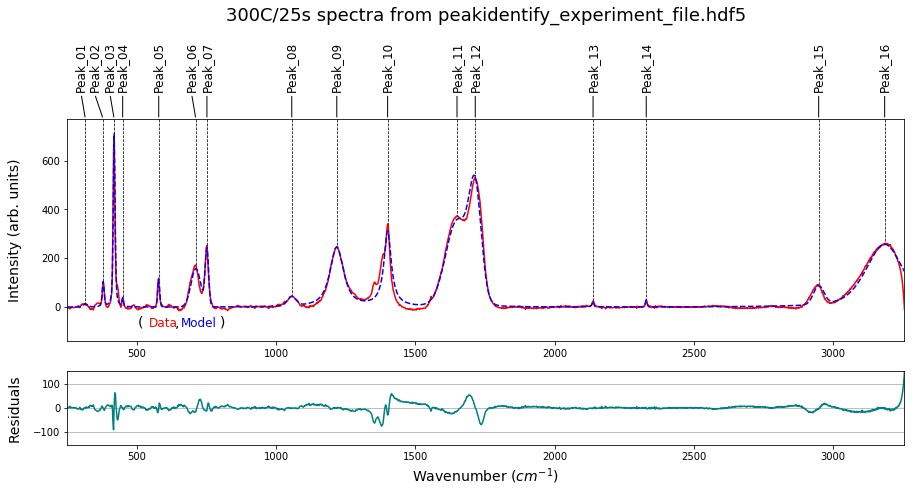

In [23]:
datavis.plot_fit('peakidentify_experiment_file.hdf5', '300C/25s')

# Example 1: Wrapper Function - peak_assignment

`peak_assignment` takes as parameters five arguments, of which 2 are optional. First, we must pass the hdf5 filename from the experiment hdf5 file, which is the `hdf5_expfilename`. The second parameter is the key from the experiment hdf5 file, which is the `expkey`. The third parameter is the the hdf5 filename from the calibration hdf5 file, which is the `hdf5_filename`. This calibration hdf5 file contains a list of all of the compounds that you want to check your unknown data for. In other words, if a compound data is not passed in this list, then the function will not look to see if that compound is present in your unknown spectrum. Each of these compounds can be refered to by the key function of the hdf5 file. The fourth parameter contains a list of strings all of the compounds that that are in that calibration file mentioned before.  This is the list that we generated above titled `list_of_compounds`, which we passed data for carbon dioxide, hydrogen, methane. An additional note is that the list of compounds from the calibration file will be listed alphabetically due to the functions of the hdf5 file format. Matching this alphabetical order is important when referencing the `list_of_compounds`. Parameter 5 is `precision`, which is an optional parameter. It is defaulted to 50, because it is an absolute wavenumber tolerance of matching between two peaks. What it does is it sets a boundary for how close the known peak position has to be to an unknown peak for the function to assign the peak. Please also checkout out the `score_table` function in the `peak_identify.py` package for a metric of confidence based upon the peak matching precision values. Finally, parameter 6 is `plot`, which is also an optional parameter. It is a Boolean which defaults to True. If True, this will plot the unknown specrta and labels for all of the peaks in said spectra. 

For our example, we won't mess with those optional parameters.

This function will output the list of known peaks for each compound and the plot for the unknown specrta and labels for all of the peaks in said spectra. Additionally, it will output a percentage of how many of the material's peaks are found in the unknown spectrum. This can be used as a metric of confidence.

The peaks that we found for CO2 are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
The peaks that we found for CarbonMonoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The peaks that we found for FormicAcid are: 
707.31
1055.9
1219.5
1400.1
1716.7
2940.6
[0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0.]
The peaks that we found for H2O are: 
1640.6
3194.4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
The peaks that we found for Hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The peaks that we found for sapphire are: 
378.71
418.14
575.97
751.21
[0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
export labelling only


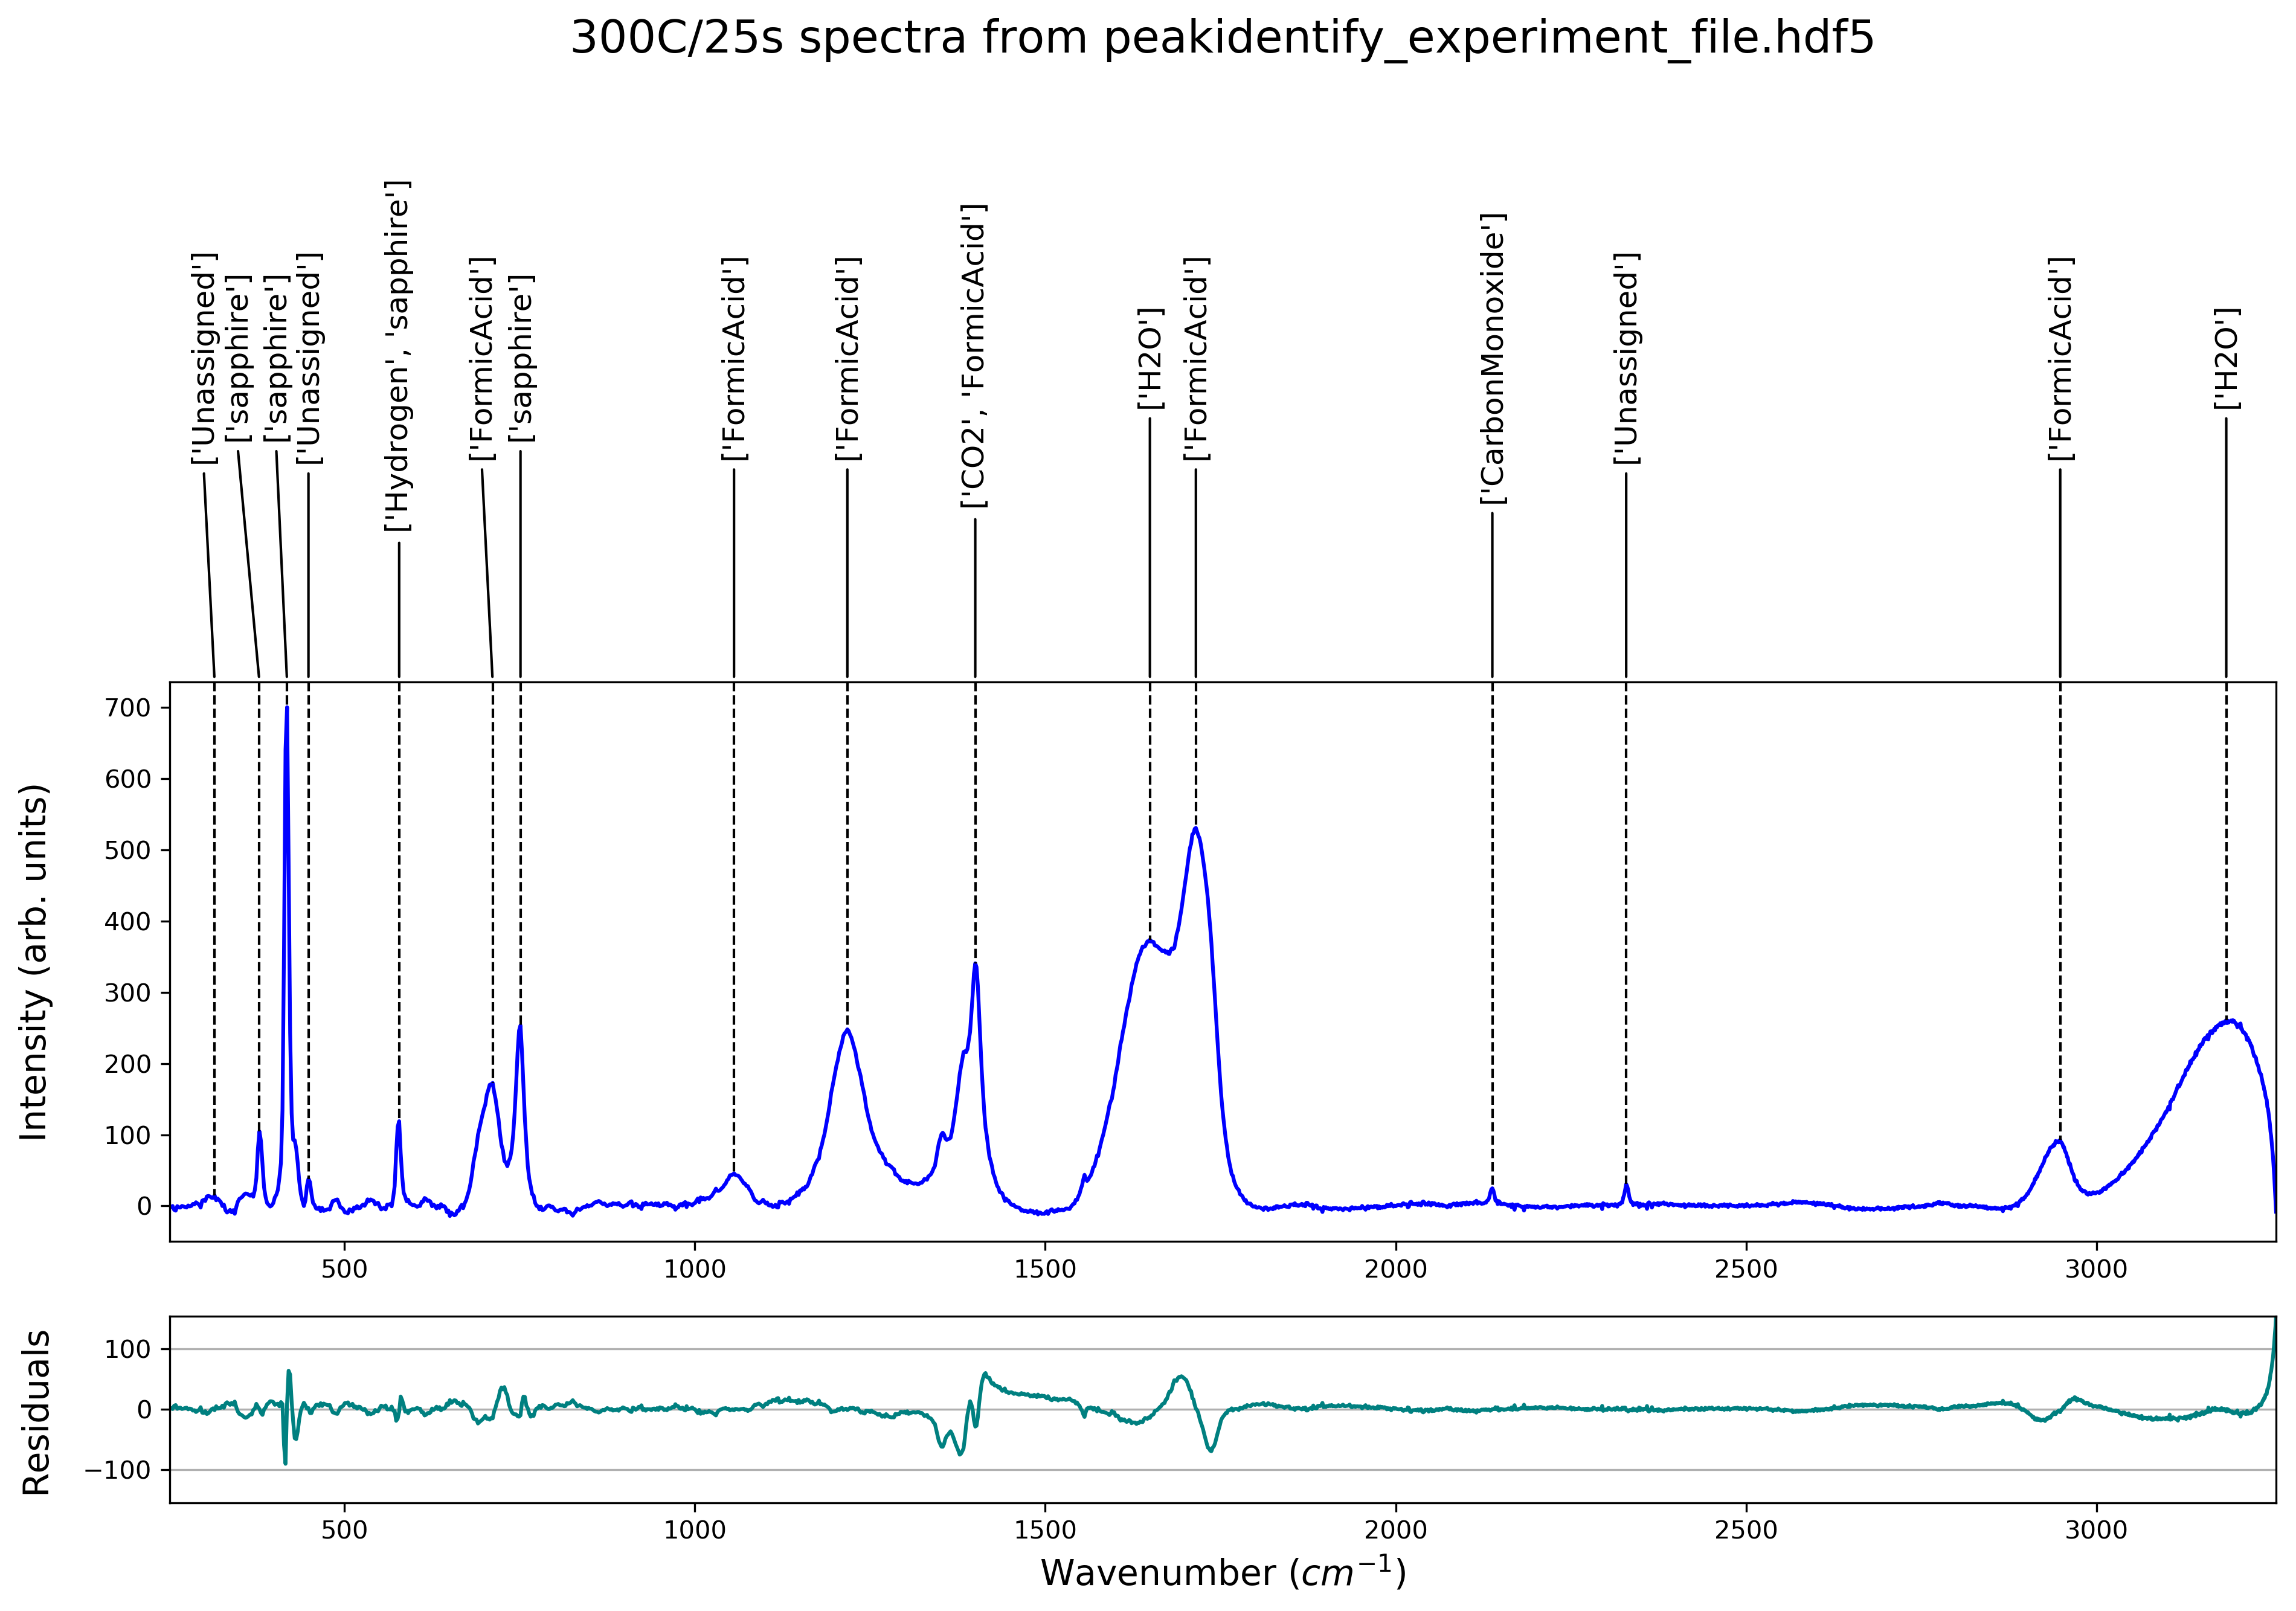

{'CO2': 50.0, 'CarbonMonoxide': 100.0, 'FormicAcid': 100.0, 'H2O': 100.0, 'Hydrogen': 25.0, 'sapphire': 100.0}


In [24]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'peakidentify_experiment_file.hdf5'
expkey ='300C/25s'
df = peakidentify.peak_assignment(hdf5_expfilename, expkey, hdf5_calfilename, 20)
# plt.savefig('peakidentify_formicAcid_300C/25s_spectra', dpi=300, bbox_inches='tight')

In [25]:
df

,0,1,2,3,4,5,6,7
0,2.66632e-06,9.47784,314.77,251.853,18.9557,12.4817,251.852,['Unassigned']
1,0.506813,4.0129,378.71,1034.01,8.0258,101.26,1028.59,['sapphire']
2,0.636782,3.84759,418.14,7306.16,7.69519,708.864,7270.35,['sapphire']
3,2.55231e-05,2.69962,448.67,193.734,5.39924,33.7084,193.741,['Unassigned']
4,0.188666,4.21062,578.11,1090.47,8.42124,114.25,1089.49,"['Hydrogen', 'sapphire']"
5,1.38778e-15,20.4979,711.51,6837.15,40.9957,156.677,6837.15,['FormicAcid']
6,6.88713e-07,7.19462,751.21,3533.44,14.3892,230.689,3533.44,['sapphire']
7,0,18.0052,1055.9,1438.24,36.0103,37.5207,1438.24,['FormicAcid']
8,0.841161,29.1589,1217.6,20781.3,58.3177,243.997,20534.1,['FormicAcid']
9,1,15.8466,1400.1,15275.1,31.6932,306.831,15166.6,"['CO2', 'FormicAcid']"


**** peakidentify_experiment_file.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09
|    |    Peak_10
|    |    Peak_11
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    counts
|    |    residuals
|    |    wavenumber


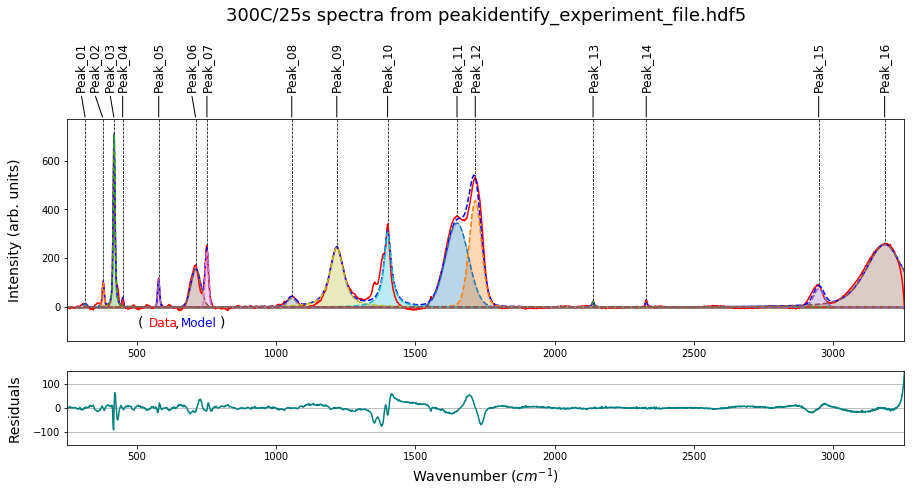

In [26]:
expkey = '300C/25s'
dataprep.view_hdf5('peakidentify_experiment_file.hdf5')
fig, ax1, ax2 = datavis.plot_fit(hdf5_expfilename, expkey)
datavis.plot_components(ax1, hdf5_expfilename, expkey, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

### Note:
Because plot = True, we see a plot of our unknown spectra with lines indicating the positions of identified possible components. 

To provide additional clarity as to the likelihood of which peaks are correctly assigned, and which are not, a dictionary is printed out after showing the plot. The dictionary contains the name of the compound, followed by a percentage. The percentage is generated by comparing the total number of peaks in the Raman spectra that are found in the unknown spectra. For example, if 1 peak out of 2 possible are found as is the case for carbon dioxide above, it will show a percentage of 50%, whereas for water if it find 2 peaks out of a possible 2, the percentage reported is 100%. This percentage provides an approximate degree of confidence for how likely it is that a compound is present. 

For this above example, because we see that water and carbon monoxide show a 100% detection percentage, we're quite confident that they are in-fact present in our unknown sample; however, as carbon dioxide only shows a 50% detection percentage, it's not very likely that it is present in our unknown sample. That said, the final value judgement is left to the user, as these percentages are just approximate guidelines. 

***

# Example 2: `dataprep.py` adjusting peaks

Often users need the ability to adjust the peaks that are fitted in the spectra. Please refer to `dataprep.py` for information on the `adjust_peaks` function. In simple terms, users can add peaks such as a peak shoulder by specifying a peak wavenumber that would correspond to the new peak's center. users can also delete peaks by specifying the peak number label such as 'Peak_01'. A new spectral fitting will occur to modify the peak fitting and labeling. The `peak_assignment` function is equipped to deal with new changes associated with the `adjust_peaks` function.

In [27]:
# when you add a new hdf5 file you use this function below
dataprep.new_hdf5('peakidentify_adjust_peaks')

In [28]:
hdf5_filename = 'peakidentify_adjust_peaks.hdf5'
key = '300C/25s'


In [29]:
dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_35s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_45s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_55s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_65s.csv')

Data from ../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv fit with compound pseudo-Voigt model.
     Results saved to peakidentify_adjust_peaks.hdf5.


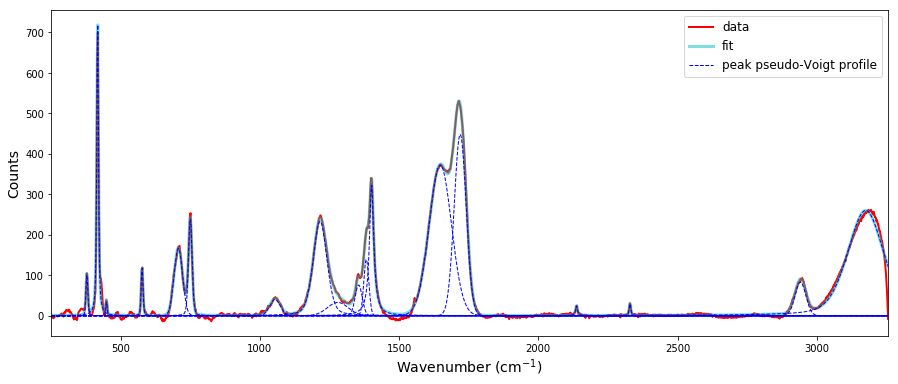

In [30]:
add_list = [1270, 1350, 1385]#, 1640]
# add_list = None
drop_list = ['Peak_01']#, 'Peak_02']
# drop_list = None

dataprep.adjust_peaks(hdf5_filename, key, add_list, drop_list, plot_fits=True)

**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


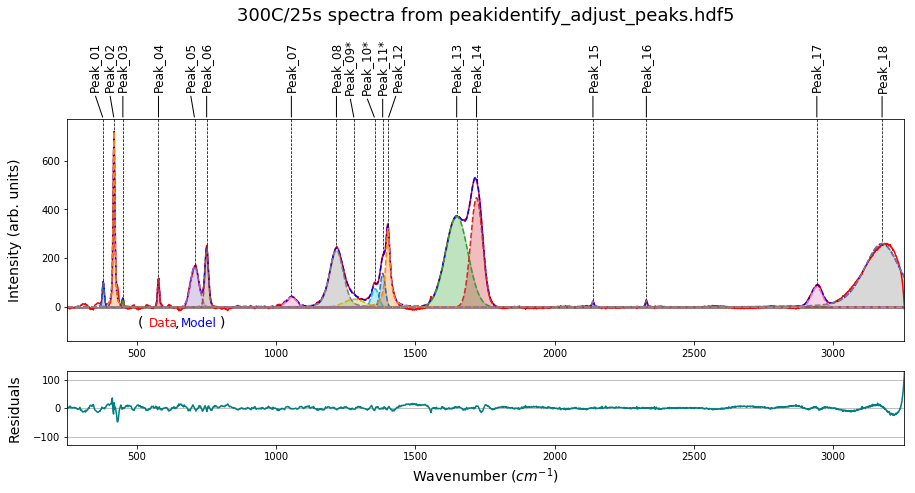

In [31]:
dataprep.view_hdf5(hdf5_filename)
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, expkey)
datavis.plot_components(ax1, hdf5_filename, expkey, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

Function did not receive normal peak.
            The function continued to look for an adjusted peak.
Peak_09*
Peak_9*
Function did not receive normal peak.
            The function continued to look for an adjusted peak.
Peak_10*
Function did not receive normal peak.
            The function continued to look for an adjusted peak.
Peak_11*
The peaks that we found for CO2 are: 
1280.4
1385.3
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
The peaks that we found for CarbonMonoxide are: 
2139.9096496496495
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The peaks that we found for FormicAcid are: 
707.31
1055.9
1219.5
1400.1
1716.7
2940.6
[0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0.]
The peaks that we found for H2O are: 
1640.6
3194.4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
The peaks that we found for Hydrogen are: 
355.6504104104104
587.3333133133133
816.0073473473473
1035.6547747747748
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
T

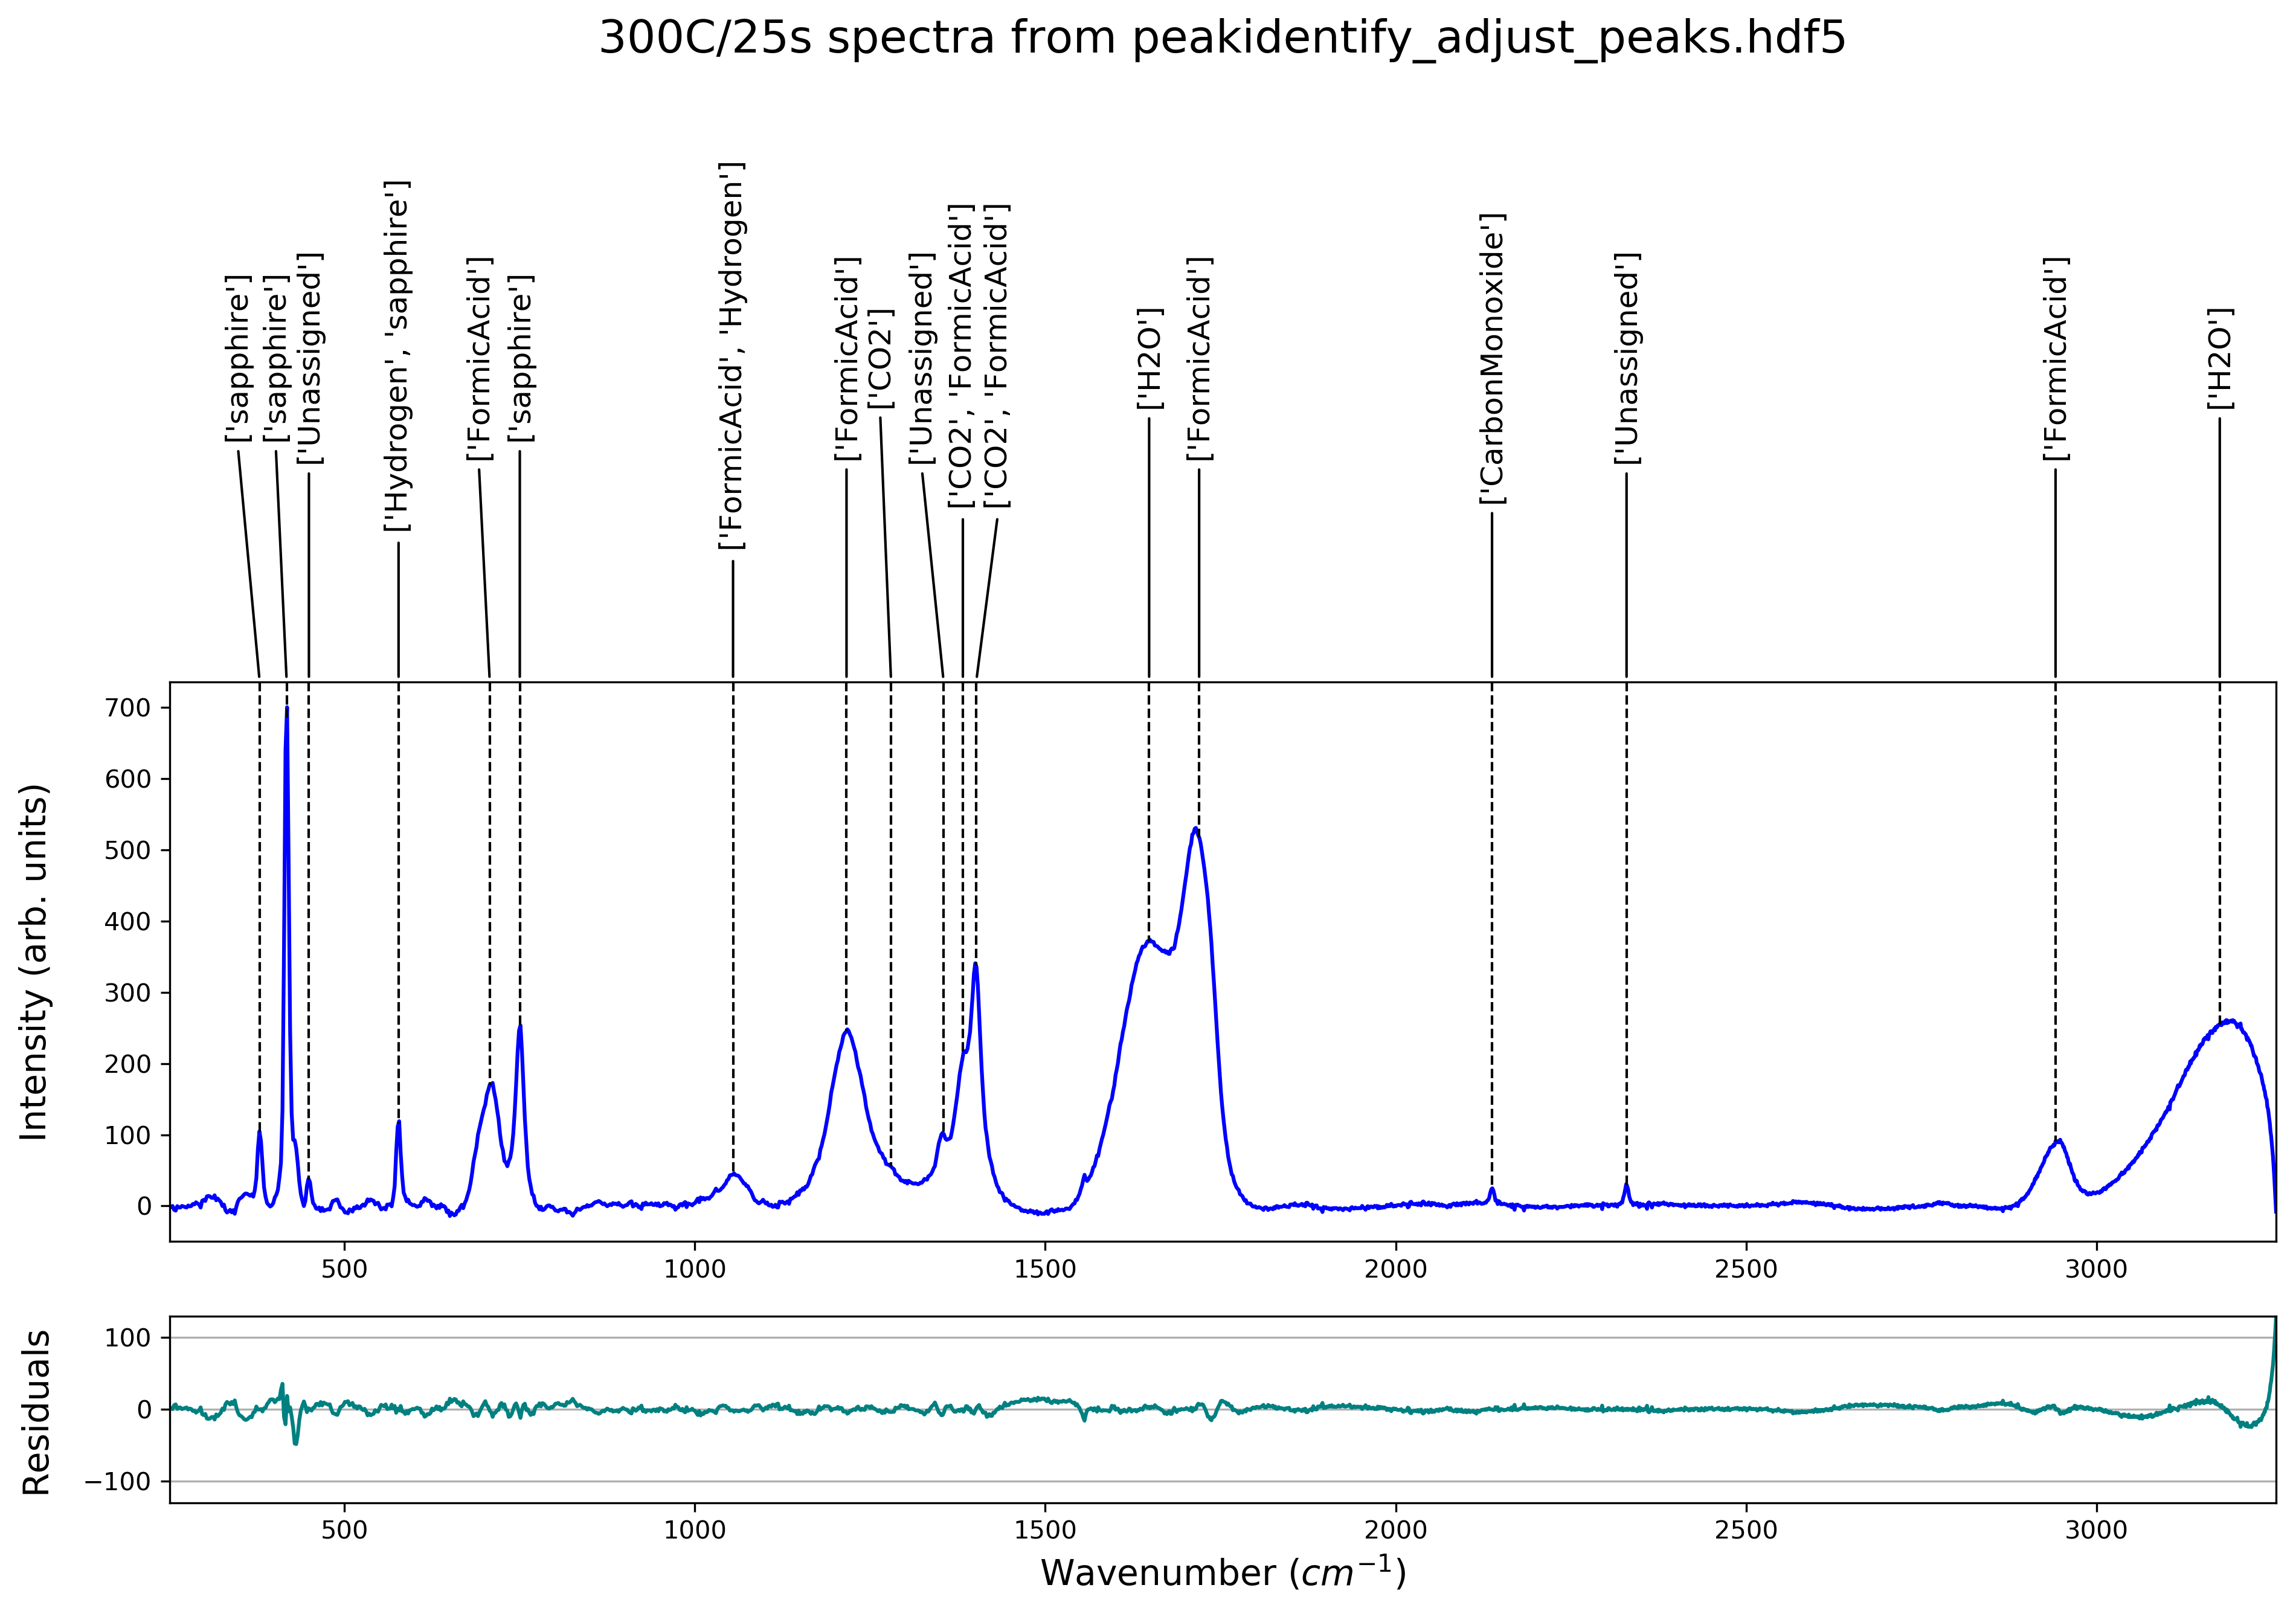

{'CO2': 150.0, 'CarbonMonoxide': 100.0, 'FormicAcid': 116.66666666666667, 'H2O': 100.0, 'Hydrogen': 50.0, 'sapphire': 100.0}


<Figure size 432x288 with 0 Axes>

In [32]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5' #update to hdf5_calfilename
hdf5_expfilename = 'peakidentify_adjust_peaks.hdf5'
df = peakidentify.peak_assignment(hdf5_expfilename, expkey, hdf5_calfilename, 20)
plt.savefig('Adjusted_peakidentification_labeled', dpi=300, bbox_inches='tight')

In [33]:
dataprep.view_hdf5('peakidentify_adjust_peaks.hdf5')

**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


**** peakidentify_adjust_peaks.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber


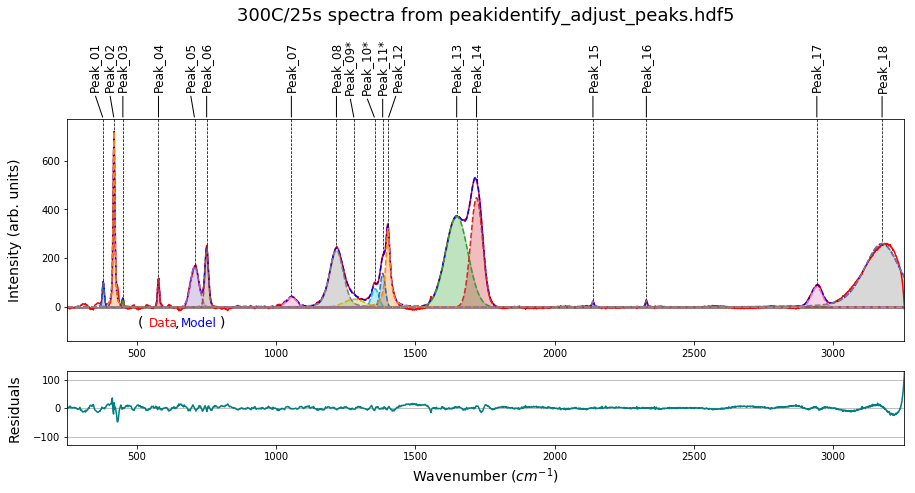

In [34]:
dataprep.view_hdf5('peakidentify_adjust_peaks.hdf5')
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, expkey)
datavis.plot_components(ax1, hdf5_filename, expkey, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

# Example 3 - Individual Functions of `peakidentify.py`


Now that you've seen the broad usage of peakidentify.py, we'll walk through the individual functions and spend a bit more time really explaining each individual use-case.

You have already been introduced to the first function, a wrapper function called `peak_assignment`. Following this, the next function is compare_unknown_to_known. This function takes in the peak positions (the wavenumber position for the peak position) for the unknown's spectrum, and compares it to the peaks positions for a single known compound. 

We'll need to generate some data to pass along, then call the function directly.

In [35]:
hdf5_calfilename = 'peakidentify_calibration_file.hdf5'
key1 = 'CarbonMonoxide'
key2 = 'Hydrogen'
key3 = 'CO2'
key4 = 'sapphire'
key5 = 'H2O'
# key6 = 'Propane'
# key7 = 'Ethane'
# key8 = 'Acetaldehyde'
key9 = 'FormicAcid'
hdf5_expfilename = 'peakidentify_experiment_file.hdf5'
expkey = '300C/25s'
# open .hdf5
calhdf5 = h5py.File(hdf5_calfilename, 'r+')
exphdf5 = h5py.File(hdf5_expfilename, 'r+')
known_compound_list=list(calhdf5.keys())
# extract spectra data
residuals = np.asarray(list(exphdf5['{}/residuals'.format(expkey)]))
unknown_x = list(exphdf5['{}/wavenumber'.format(expkey)])
unknown_y = list(exphdf5['{}/counts'.format(expkey)])
# extract fitted peak center values
co_peaks = []
H_peaks = []
CO2_peaks = []
sapphire_peaks = []
H2O_peaks = []
prop_peaks = []
ethane_peaks = []
alde_peaks = []
formic_peaks = []
unknown_peaks = []
for _,peak in enumerate(list(calhdf5[key1])[:-3]):
    co_peaks.append(list(calhdf5['{}/{}'.format(key1, peak)])[0][2])

for _,peak in enumerate(list(calhdf5[key2])[:-3]):
    H_peaks.append(list(calhdf5['{}/{}'.format(key2, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key3])[:-3]):
    CO2_peaks.append(list(calhdf5['{}/{}'.format(key3, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key4])[:-3]):
    sapphire_peaks.append(list(calhdf5['{}/{}'.format(key4, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key5])[:-3]):
    H2O_peaks.append(list(calhdf5['{}/{}'.format(key5, peak)])[0][2])
# for _,peak in enumerate(list(calhdf5[key6])[:-3]):
#     prop_peaks.append(list(calhdf5['{}/{}'.format(key6, peak)])[0][2])
# for _,peak in enumerate(list(calhdf5[key7])[:-3]):
#     ethane_peaks.append(list(calhdf5['{}/{}'.format(key7, peak)])[0][2])
# for _,peak in enumerate(list(calhdf5[key8])[:-3]):
#     alde_peaks.append(list(calhdf5['{}/{}'.format(key8, peak)])[0][2])
for _,peak in enumerate(list(calhdf5[key9])[:-3]):
    formic_peaks.append(list(calhdf5['{}/{}'.format(key9, peak)])[0][2])
for i,peak in enumerate(list(exphdf5[expkey])[:-3]):
    if i < 9:
        unknown_peaks.append(list(exphdf5['{}/Peak_0{}'.format(expkey, i+1)])[0][2])
    else:
        unknown_peaks.append(list(exphdf5['{}/Peak_{}'.format(expkey, i+1)])[0][2])

`compare_unknown_to_known` takes 3 parameters. The first parameter, combined_peaks is the peak positions of the unknown peaks. The second parameter, known_peaks, is the peak positions of one of the known compounds. The third parameter is precision, which is the maximum percentage difference between an unknown peak position and a known peak position that will be accepted as close enough to give a positive assignment. The function returns a parameter association_matrix, which contains a list of either 1 or 0, which is the assignment value of whether or not a peak from the unknown peak set was found in the passed known peak set. 

In [36]:
peakidentify.compare_unknown_to_known(unknown_peaks, H_peaks, 10)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [38]:
peakidentify.compare_unknown_to_known(unknown_peaks, CO2_peaks, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
peakidentify.compare_unknown_to_known(unknown_peaks, sapphire_peaks, 10)

[0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
peakidentify.compare_unknown_to_known(unknown_peaks, H2O_peaks, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])

So, this function, when called to compare water to the unknown peaks, or carbon monoxide to the unknown peaks, we see that it returns an array of 1 and 0. This array is an assignment array. If the array contains a 0, the peak in that position is not found in the known compound. For example, for the water peak comparison, the value of the returned array is 1 at position 0. That means that it is assigning the peak found at position 0 to be possibly coming from water. The 0 in position 2 implies that the unknown peak is not found in water. If we look at position 2 in the carbon monoxide comparison, we see that it is a 1 there. This implies that the peak in position 2, is likely not coming from water, and could possibly be coming from carbon monoxide.

The next function to investigate is the `peak_position_comparisons`. It takes four parameters. The first is the list of unknown peaks, and the second is the complete list of peaks for known compounds. The third is the list of compounds that the wrapper function should search through. The fourth is the complete association matrix output from the `compare_unknown_to_known` function. By appending together the matrices returned by that function, the full association_matrix is built. We will build a full association matrix, and then pass it to our `peak_position_comparisons` function.

In [41]:
#Build our test data.
association_matrix_beta = []
known_peaks_beta = [CO2_peaks, co_peaks,formic_peaks, H_peaks, H2O_peaks, sapphire_peaks]
# Note the order that you append to the association_matrix_beta matters 
# with the known compound list so make sure these match alphabetically
# Known peaks beta, order does not matter
# association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, alde_peaks, 10))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, CO2_peaks, 20))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, co_peaks, 20))
# association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, ethane_peaks, 10))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, formic_peaks, 20))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, H_peaks, 20))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, H2O_peaks, 20))
association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, sapphire_peaks, 20))
# association_matrix_beta.append(peakidentify.compare_unknown_to_known(unknown_peaks, prop_peaks, 10))

print(association_matrix_beta)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
[0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]), array([0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


In [42]:
known_compound_list

['CO2', 'CarbonMonoxide', 'FormicAcid', 'H2O', 'Hydrogen', 'sapphire']

In [43]:
peakidentify.peak_position_comparisons(unknown_peaks, known_peaks_beta, association_matrix_beta, hdf5_calfilename)


[['Unassigned'],
 ['sapphire'],
 ['sapphire'],
 ['Unassigned'],
 ['H2O', 'sapphire'],
 ['FormicAcid'],
 ['sapphire'],
 ['FormicAcid'],
 ['FormicAcid'],
 ['CO2', 'FormicAcid'],
 ['Hydrogen'],
 ['FormicAcid'],
 ['CarbonMonoxide'],
 ['Unassigned'],
 ['FormicAcid'],
 ['Hydrogen']]

This function returns a list that shows all of the possible assignments for every peak, in a text format. We can see that for the unknown peak in position 4 and position 5, there is a potential for that peak to have come from H2O and Formic Acid. If this function does not find any possible compound for a peak, it returns a value of 'unassigned', which we will show below. Changes to the association matrix can be made manually as seen below.

In [44]:
peakidentify.peak_position_comparisons(unknown_peaks, [CO2_peaks], [[1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['CO2'],
 ['Unassigned'],
 ['CO2'],
 ['CO2'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

In [45]:
peakidentify.peak_position_comparisons(unknown_peaks, [CO2_peaks], [[0.,0.,0.,0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], hdf5_calfilename)

[['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['CO2'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned'],
 ['Unassigned']]

As you can see, if the peak isn't found, it labels the value as 'unassigned'! 

Additionally, the association matrix list of 1s and 0s directly correlates to the list of possible assignments, thus changes in the matrix will affect the possible assignments.

##### NOTE: Except for plotting_peak_assignments(), Individual functions like peak_position_comparisons() will not have labelling functionality outside of the wrapper function. This means while the ones and zeros in the association matrix can change the unknown_peak_assignments as seen above and below, changing the labels for these assignments can only be done before plotting_peak_assignments() or the peak_assignment() wrapper function. 



The next function to be explored is `percentage_of_peaks_found`. This function calculates a percentage value for how many of the peaks from a known compound were found in the unknown peak list. This function takes 3 parameters. The first is a list of known peaks, the second is the full association matrix, and the third is the filename of the calibration spectra. The function returns a dictionary where the keys are all of the titles of the known compounds, and the values of the keys are all of the percentages of found peaks.

In [46]:
# THe known peaks found must match the order from the known_compound_list
peakidentify.percentage_of_peaks_found( [CO2_peaks, co_peaks,formic_peaks, H_peaks, H2O_peaks, sapphire_peaks], 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 50.0,
 'CarbonMonoxide': 100.0,
 'FormicAcid': 100.0,
 'H2O': 25.0,
 'Hydrogen': 100.0,
 'sapphire': 100.0}

In [47]:
peakidentify.percentage_of_peaks_found(known_peaks_beta, 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 50.0,
 'CarbonMonoxide': 100.0,
 'FormicAcid': 100.0,
 'H2O': 25.0,
 'Hydrogen': 100.0,
 'sapphire': 100.0}

Ok, above you can see that 100% of the peaks of hydrogen are found, 100% of the carbon monoxide peaks,100% of the formic acid peaks, and 100% of the sapphire peaks. This is pretty reasonable, as the unknown spectra was made up of these molecules with a sapphire ball as a reference spectra, and it's a good sign. There is a 50% find-rate for carbon dioxide. If we look at the absolute peak positions for carbon dioxide, we see that this is pretty reasonable, as one of the peaks of carbon dioxide overlaps within a 20 wavenumber precision range of an unknown peak. However, none of the other carbon dioxide peaks overlap within that precision range, so overall we get a pretty low percentage of carbon dioxide peaks found. Similar problem with water. Ultimately, it is up to the user to be sure that the percentages and compound list make sense, and to interpret what the percentages mean. 



In [48]:
# Test pecentage of peaks found case
# Adding random lists not associated with the known compound list will throw off the calculations of found peak percent
peakidentify.percentage_of_peaks_found( [CO2_peaks, [1], co_peaks,formic_peaks, H_peaks, H2O_peaks, sapphire_peaks], 
                          association_matrix_beta, hdf5_calfilename)

{'CO2': 50.0,
 'CarbonMonoxide': 100.0,
 'FormicAcid': 600.0,
 'H2O': 16.666666666666664,
 'Hydrogen': 50.0,
 'sapphire': 200.0}

The next function in the peakidentify system is the `plotting_peak_assignments` function, which plot the full unknown spectra, and labels each of the peaks in the unknown spectra with all of the possible compounds present. It takes as inputs 49parameters. The first is the unknown_x data from before, and the second is the unknown_y data, also from before. The third input is the list of unknown peaks, and the fourth input is the list of assignments for each of those unknown peaks. 
The rest of the inputs are the filenames and keys from the experimental and calibration data.
It does not return any values, but it does generate a plot of all of the input information. It does however need a peak_labels input from which you can assign whatever labels you want if the _exportlabelinput_ = True.

In [49]:
peak_labels =["['Hey!']",
 "['HERE']",
 "['are']",
 "['Unassigned']",
 "['some', 'labels']",
 "['that']",
 "['one']",
 "['can']",
 "['make']",
 "['FormicAcid','H2O']",
 "['using']",
 "['the']",
 "['exportlabelinput']",
 "['function']",
 "['when']",
 "['True']"]

[['Unassigned'], ['sapphire'], ['sapphire'], ['Unassigned'], ['H2O', 'sapphire'], ['FormicAcid'], ['sapphire'], ['FormicAcid'], ['FormicAcid'], ['CO2', 'FormicAcid'], ['Hydrogen'], ['FormicAcid'], ['CarbonMonoxide'], ['Unassigned'], ['FormicAcid'], ['Hydrogen']]
export labelling only


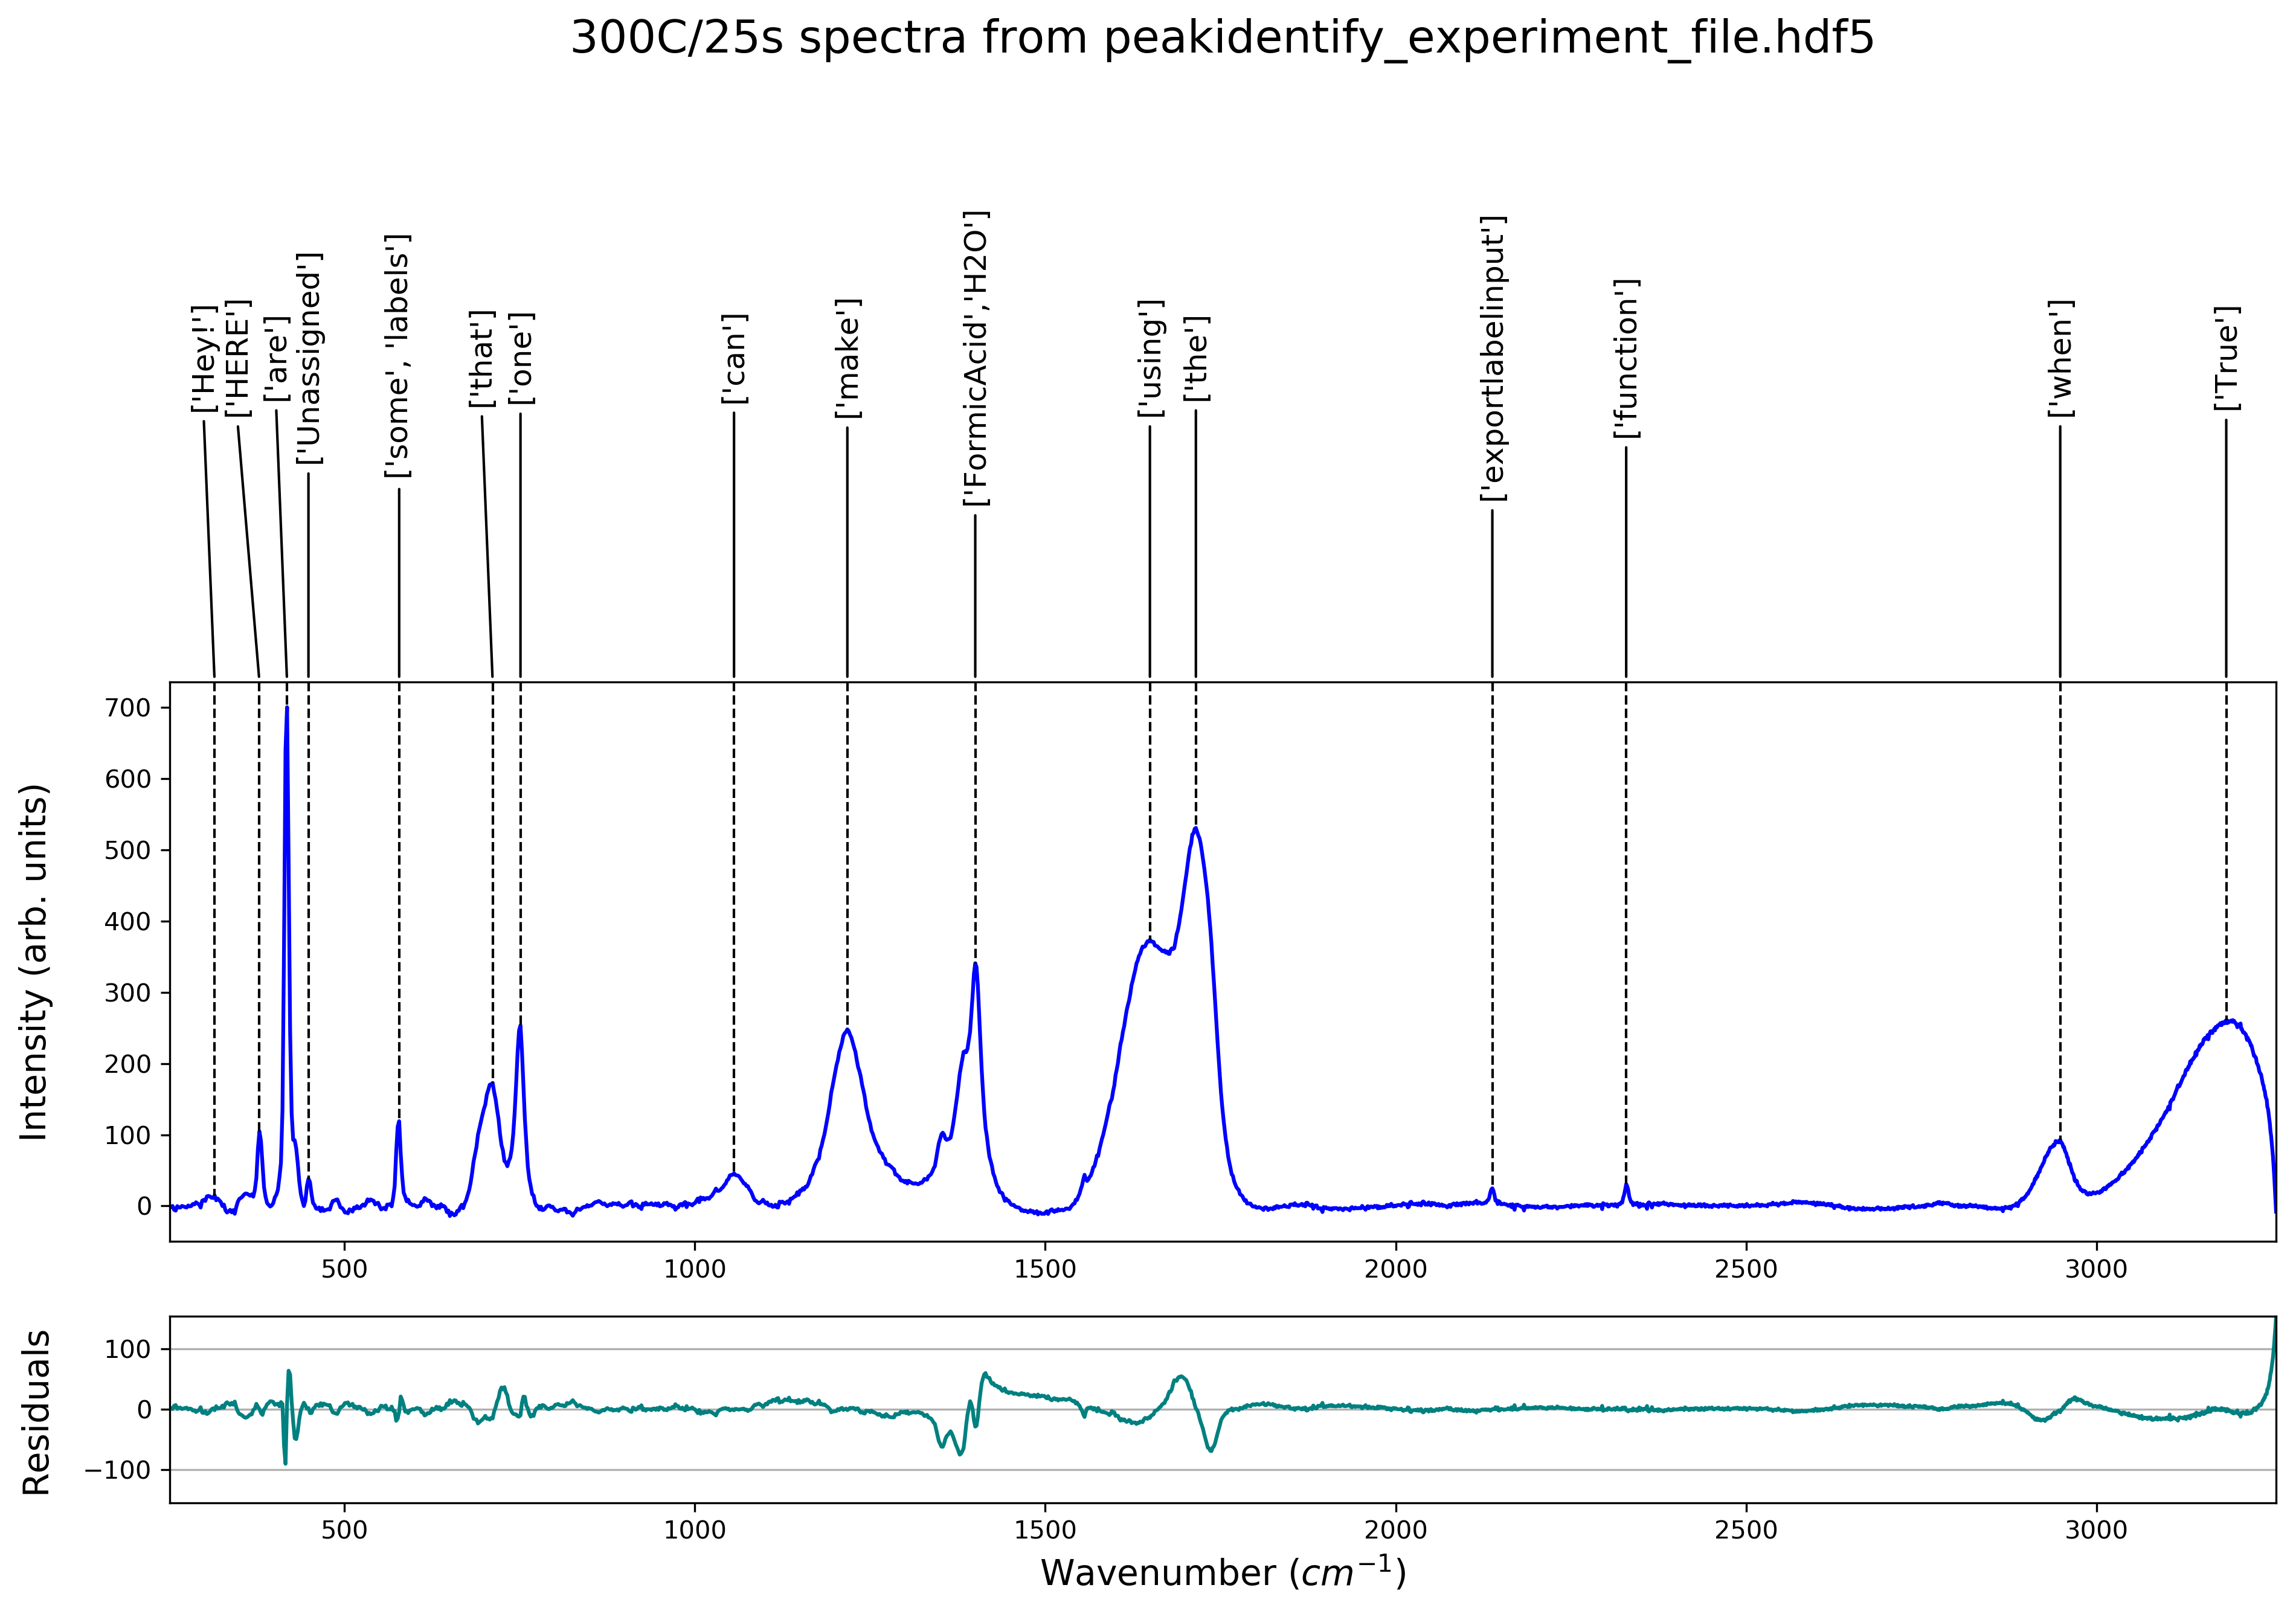

In [50]:
unknown_peak_assignments_beta = peakidentify.peak_position_comparisons(unknown_peaks, known_peaks_beta, association_matrix_beta, hdf5_calfilename)
print(unknown_peak_assignments_beta)
peakidentify.plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments_beta, hdf5_expfilename, hdf5_calfilename, expkey, peak_labels, exportlabelinput = True )

[['Unassigned'], ['sapphire'], ['sapphire'], ['Unassigned'], ['H2O', 'sapphire'], ['FormicAcid'], ['sapphire'], ['FormicAcid'], ['FormicAcid'], ['CO2', 'FormicAcid'], ['Hydrogen'], ['FormicAcid'], ['CarbonMonoxide'], ['Unassigned'], ['FormicAcid'], ['Hydrogen']]


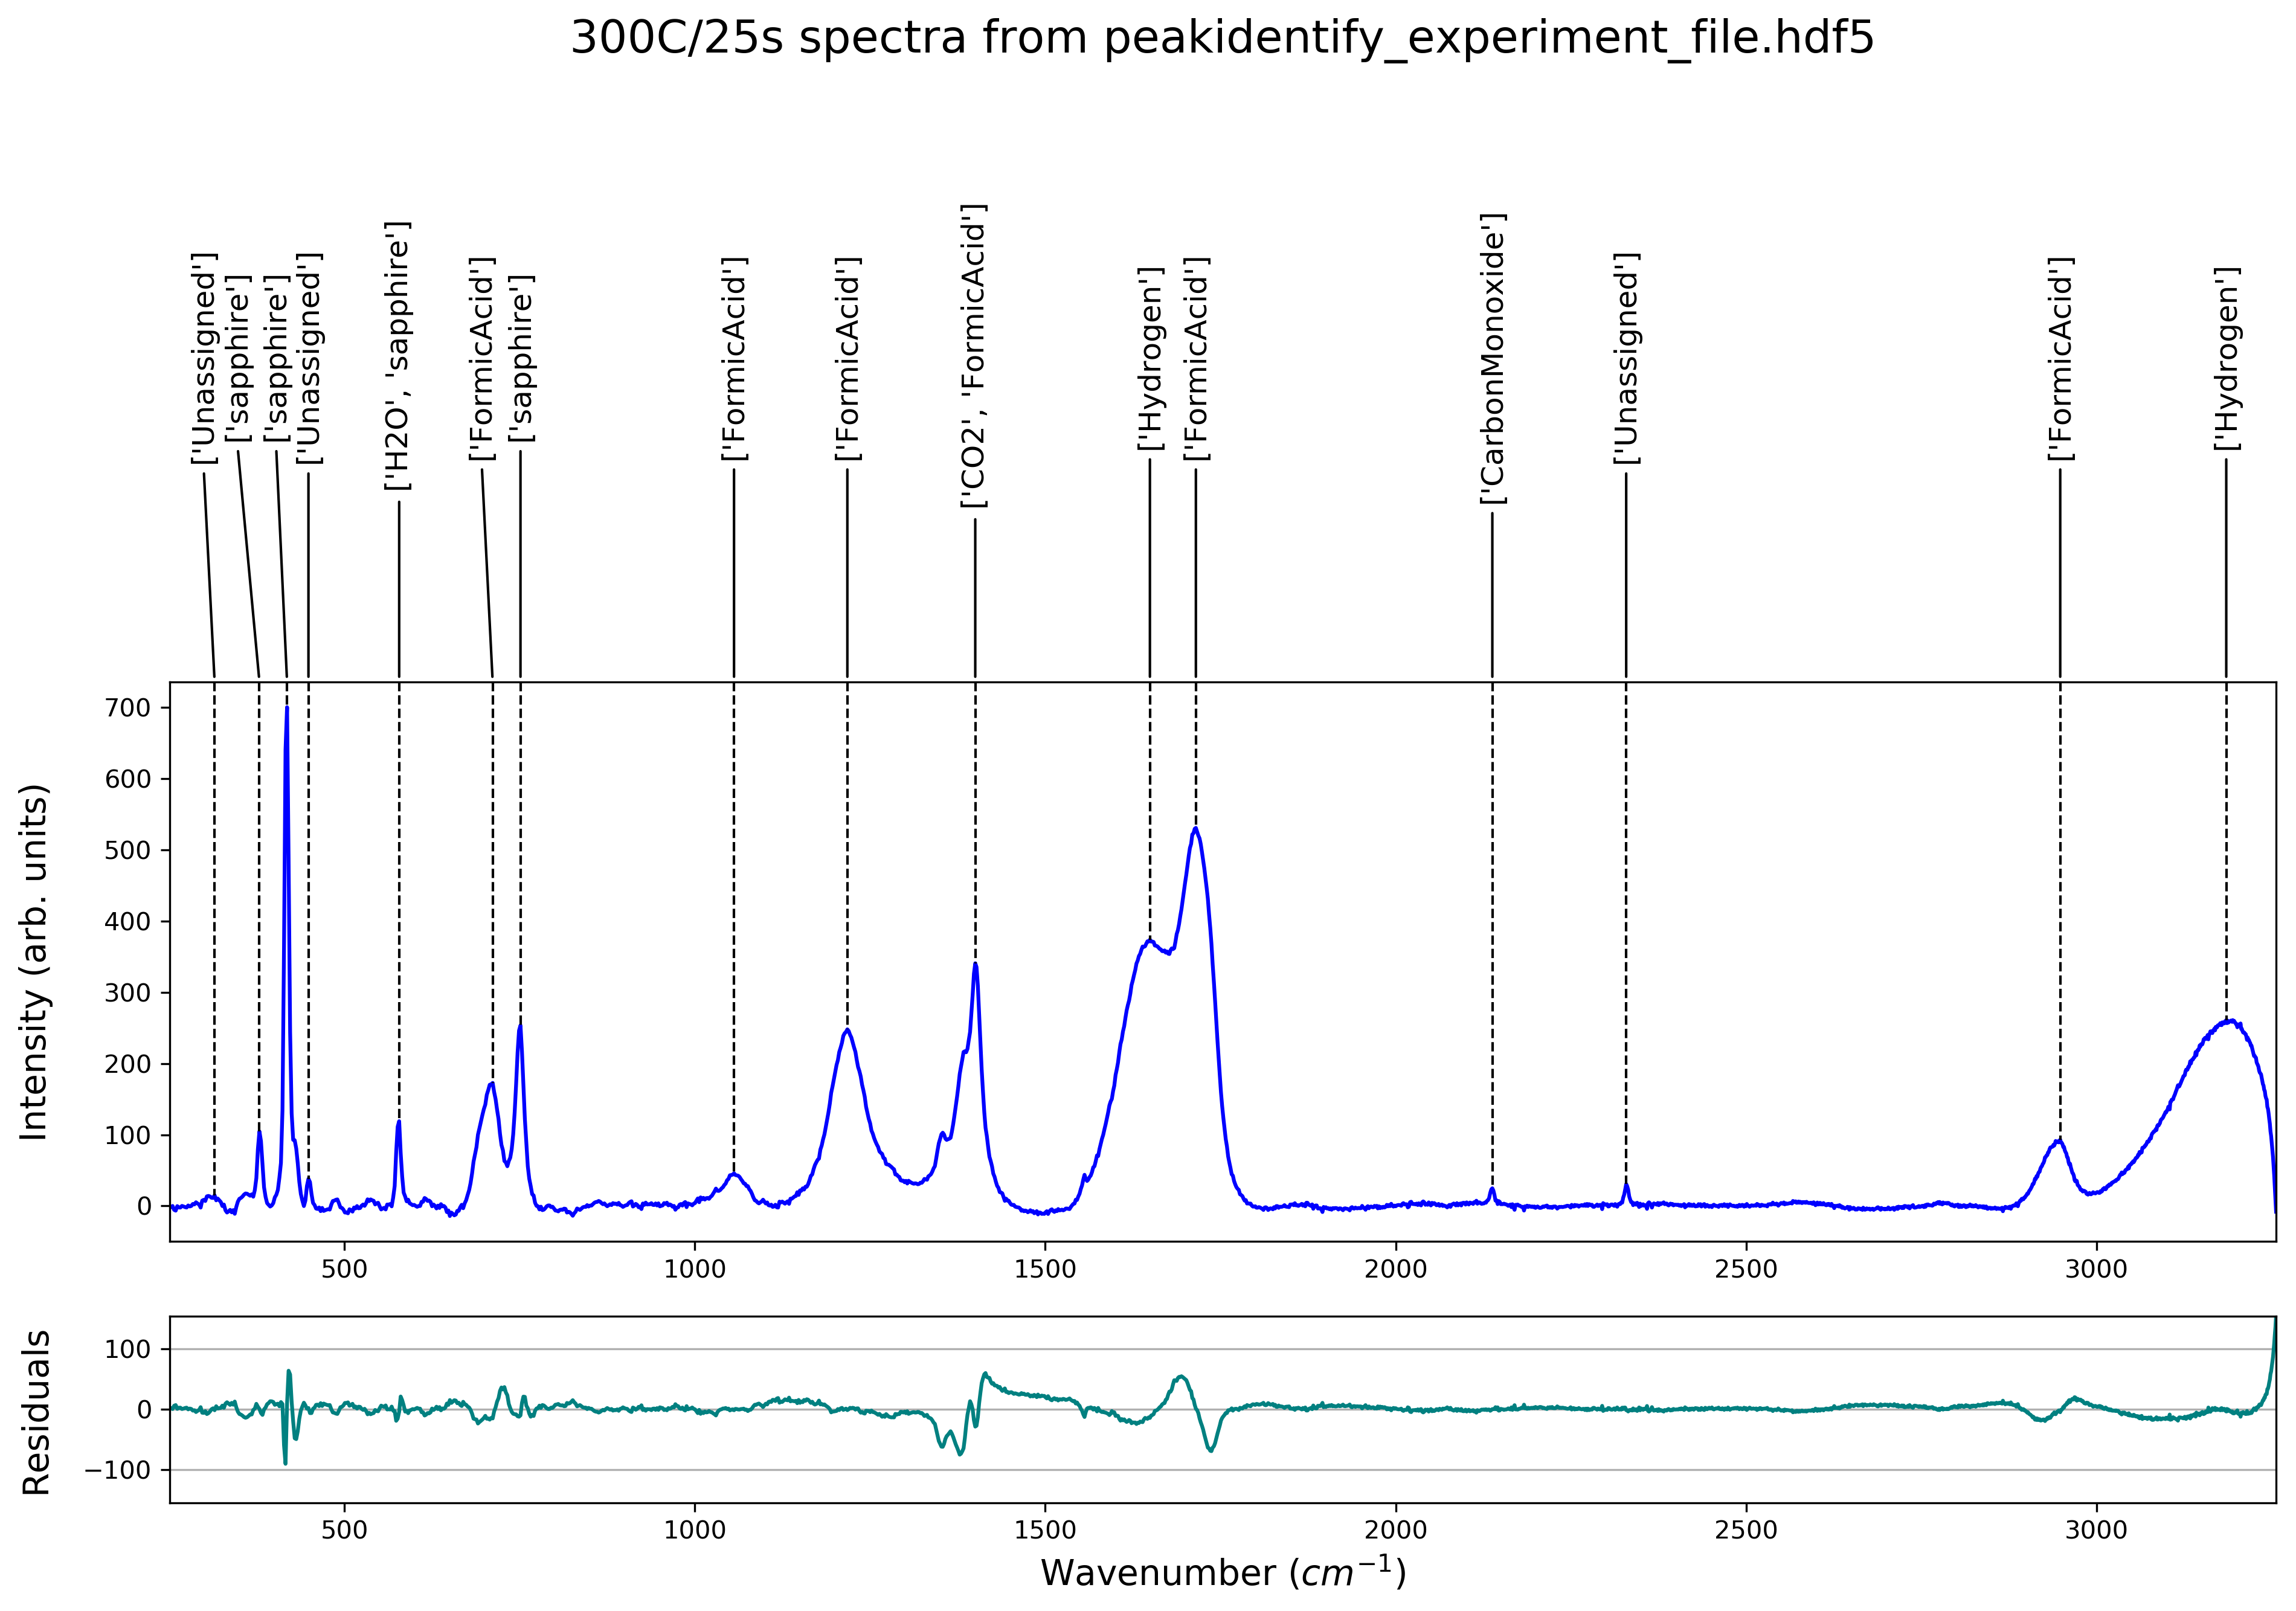

In [51]:
unknown_peak_assignments_beta = peakidentify.peak_position_comparisons(unknown_peaks, known_peaks_beta, association_matrix_beta, hdf5_calfilename)
print(unknown_peak_assignments_beta)
peakidentify.plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments_beta, hdf5_expfilename, hdf5_calfilename, expkey, peak_labels, exportlabelinput = False )

Here, we see the exact same plot as above, when we just interacted with the wrapper function. Ultimately, the plot generated should be exactly the same, given that it was generated using the same data. 
You can change the inputs for the known peaks, but you need to make sure your list of compounds is alphabetical.

## Example 4: Score_table for 1D Wavenumber
This is a metric of confidence. This score function should be considered as a first visual grading that your peaks are close enough to determine matching. We will provide a simplistic 1D Euclidean distance calculation. 

The reciprocal of the distance is returned as a percentage of distance comparison in the x dimension with 1 equalling peak centers that are super close and 0 super far away respectively. A tuple of the two peak locations compared is returned for visual confirmation of the score.

This scoring function also includes the user input for the choice of normalizing the peak distance scores and sorting them based on the  kth highest score in the peak set. This normalization is performed to bring a better understanding to the peak distance confidence score, and it also allows for future work to be done in determining the best kth highest score normalization to be used. The default k for `peak_1d_score` is zero and is simply an integer.

In [52]:
peakidentify.peak_1d_score(unknown_peaks,H2O_peaks,scoremax =1, precision = 20)

The `score_max` function calls upon the `peak_1D_score` to get the highest score = 1 and then will normalize the rest of the score data respectively. Here, the user can input different k values for the # k highest score to be normalized over.

In [53]:
scoremaxk1=peakidentify.score_max(unknown_peaks,H2O_peaks,k=1, precision = 20)

The `score_sort` function just appends the score max normalized scores and peak tuples to a list. There is no additional sorting feature added since the score max function already sorts the scores from the lowest to highest peak tuples compared.

In [54]:
data=peakidentify.score_sort(unknown_peaks,H2O_peaks,k=1, precision = 20)
print(data)

[([1.0, 0.9417475728155218], [(1649.3, 1640.6), (3185.1, 3194.4)])]


The user should spend some time evaluating how to visually grade their peak distance closeness. It might make sense in some cases to not have a normalized highest peak score. This score_table showcases how different k values interact with the score grading and precision. The final k value will output the original not normalized score. The score_table should be used for each known compound, not the collection of known_peaks like known_peaks_beta.

In [55]:
precision = 20
result1 = peakidentify.score_table(unknown_peaks,H2O_peaks, precision, 'Formic3.6wt%', 'H2O')
result2 = peakidentify.score_table(unknown_peaks,co_peaks, precision, 'Formic3.6wt%', 'CO')
result3 = peakidentify.score_table(unknown_peaks,CO2_peaks, precision, 'Formic3.6wt%', 'CO2')
result4 = peakidentify.score_table(unknown_peaks,sapphire_peaks, precision, 'Formic3.6wt%', 'sapphire')
result5 = peakidentify.score_table(unknown_peaks,H_peaks, precision, 'Formic3.6wt%', 'H')

Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The variable
        scoremax has been reset back to 1. This is equivalent to 
        your unnormalized score.
Function did not receive a scoremax variable. The va

In [56]:
result1

,Formic3.6wt%_vs_H2O_peak_Scores normalized over the #1 highest score in the peak set,Peaks,Formic3.6wt%_vs_H2O_peak_Scores normalized over the #2 highest score in the peak set,Peaks,Formic3.6wt%_vs_H2O_peak_Scores Unnormalized,Peaks
0,1.000000,"(1649.3, 1640.6)",1.061856,"(1649.3, 1640.6)",0.103093,"(1649.3, 1640.6)"
1,0.941748,"(3185.1, 3194.4)",1.000000,"(3185.1, 3194.4)",0.097087,"(3185.1, 3194.4)"


#### Conclusion
The peak assignment module is a powerful tool in identification of Raman spectra. This module is designed to attach a label to each fitted peak in an unknown spectra based on fed in known calibration spectra.These functions are primarily accessed in an automated fashion via the peakidentify.py module. It is the most efficient with correct user-inputted precision values and the correct calibration files attached. In some cases, for each of vertical line, you can see that the peak labelling function has assigned not just one, but two possible peaks to this position. This is possible with chemicals that have common degradation derivatives, there might be instances with two peaks peaks that exist in similar locations within the `precision` error bound. There is also a possibility of overfitting calibration data with unnecessary calibration inputs
To provide additional clarity as to the likelihood of which peaks are correctly assigned, and which are not, a dictionary is printed out after showing the plot. The dictionary contains the name of the compound, followed by a percentage. The percentage is generated by comparing the total number of peaks in the Raman spectra that are found in the unknown spectra. For example, if 1 peak out of 10 possible are found as is the case for carbon dioxide above, it will show a percentage of 10%, whereas for water if it find 3 peaks out of a possible 3, the percentage reported is 100%. This percentage provides an approximate degree of confidence for how likely it is that a compound is present. The final value judgement is left to the user, as these percentages are just approximate guidelines. 

***

Need to close out your hdf5 files or else you cannot remove them later on

In [57]:
exphdf5.close()

In [58]:
calhdf5.close()

In [59]:
test_example.close()

Remove the hdf5 files to keep the system data clean

In [60]:
os.remove('peakidentify_label_test.hdf5') 
os.remove('peakidentify_adjust_peaks.hdf5')
os.remove('peakidentify_experiment_file.hdf5')
os.remove('peakidentify_calibration_file.hdf5')